In [1]:
import pandas as pd
from environment import root_dir
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import itertools
import seaborn as sns

In [2]:
task_vis_results = pd.read_pickle(f"{root_dir}/results/results-tree-vis-v3.pkl")
generation_results = pd.read_pickle(f"{root_dir}/results/results-generation.pkl")
compare_results = pd.read_pickle(f"{root_dir}/results/results-tree-compare.pkl")

In [3]:
mpl.rcParams.update(mpl.rcParamsDefault)
colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
markers = ['o', '<', 's', 'p', 'P', 'X', 'D', 'd', 'v', 'h', 'H', '8', '>', '*', '1', '2', '3', '4', 'x', '+', '|', '_']
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
# plt.rcParams['text.usetex'] = True
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

In [4]:
models = {
    "xai/grok-3-mini-beta": {
        "label": "Grok 3 mini beta", 
        "color": colors[0],
    },
    "deepseek-ai/deepseek-reasoner": {
        "label": "DeepSeek-R1", 
        "color": colors[1],
    },   
}


metrics = {
    "average_forgetting_rate": {
        "label": "Forgetting Rate",
    },
    "average_solution_count": {
        "label": "Average Solution Count",
    },
    "overall_average_verification_rate": {
        "label": "Average Verification Rate",
    },
    "filtered_ajd": {
        "label": "Average Jump Distance",
    },
    "average_success_rate": {
        "label": "Average Success Rate",
    },
    "average_overthinking_rate": {
        "label": "Average Overthinking Rate",
    },
    "average_correlation": {
        "label": "Pass@1",
    },
}

dataset_metrics = {
    "math500": [
        "average_forgetting_rate",
        "average_solution_count",
        "overall_average_verification_rate",
        "filtered_ajd",
        "average_correlation",
    ],
    "game24": [
        "average_forgetting_rate",
        "average_solution_count",
        "overall_average_verification_rate",
        "filtered_ajd",
        "average_success_rate",
        "average_overthinking_rate",
        "average_correlation",
    ],
}

final_datasets = {
    'math500': "MATH-500", 
    'game24': "Game of 24",
}
final_metrics = [
    "average_correlation", 
    "average_solution_count",
    "filtered_ajd",
    "average_success_rate",
    "average_overthinking_rate",
    "overall_average_verification_rate",
    "average_forgetting_rate",
]

In [5]:
def get_row(df, **kwargs):
    condition = None
    for key, value in kwargs.items():

        if condition is None:
            condition = df[key] == value
        else:
            condition &= df[key] == value
    return df[condition].reset_index(drop=True)

In [6]:
reasoning_metrics = {}
for dataset in final_datasets:
    reasoning_metrics[dataset] = {}
    for model in models:
        reasoning_metrics[dataset][model] = {}
        for temperature in [0, 0.33, 0.66, 1]:
            row = get_row(
                task_vis_results, 
                model_name=model, 
                dataset_name=dataset, 
                temperature = temperature,
            )
            reasoning_metrics[dataset][model][temperature] = {}
            for metric in final_metrics:
                reasoning_metrics[dataset][model][temperature][metric] = row.iloc[0][metric]


In [7]:
temperatures = [0, 0.33, 0.66, 1]
alphas = [0.5, 0.7, 0.85, 1.0]  

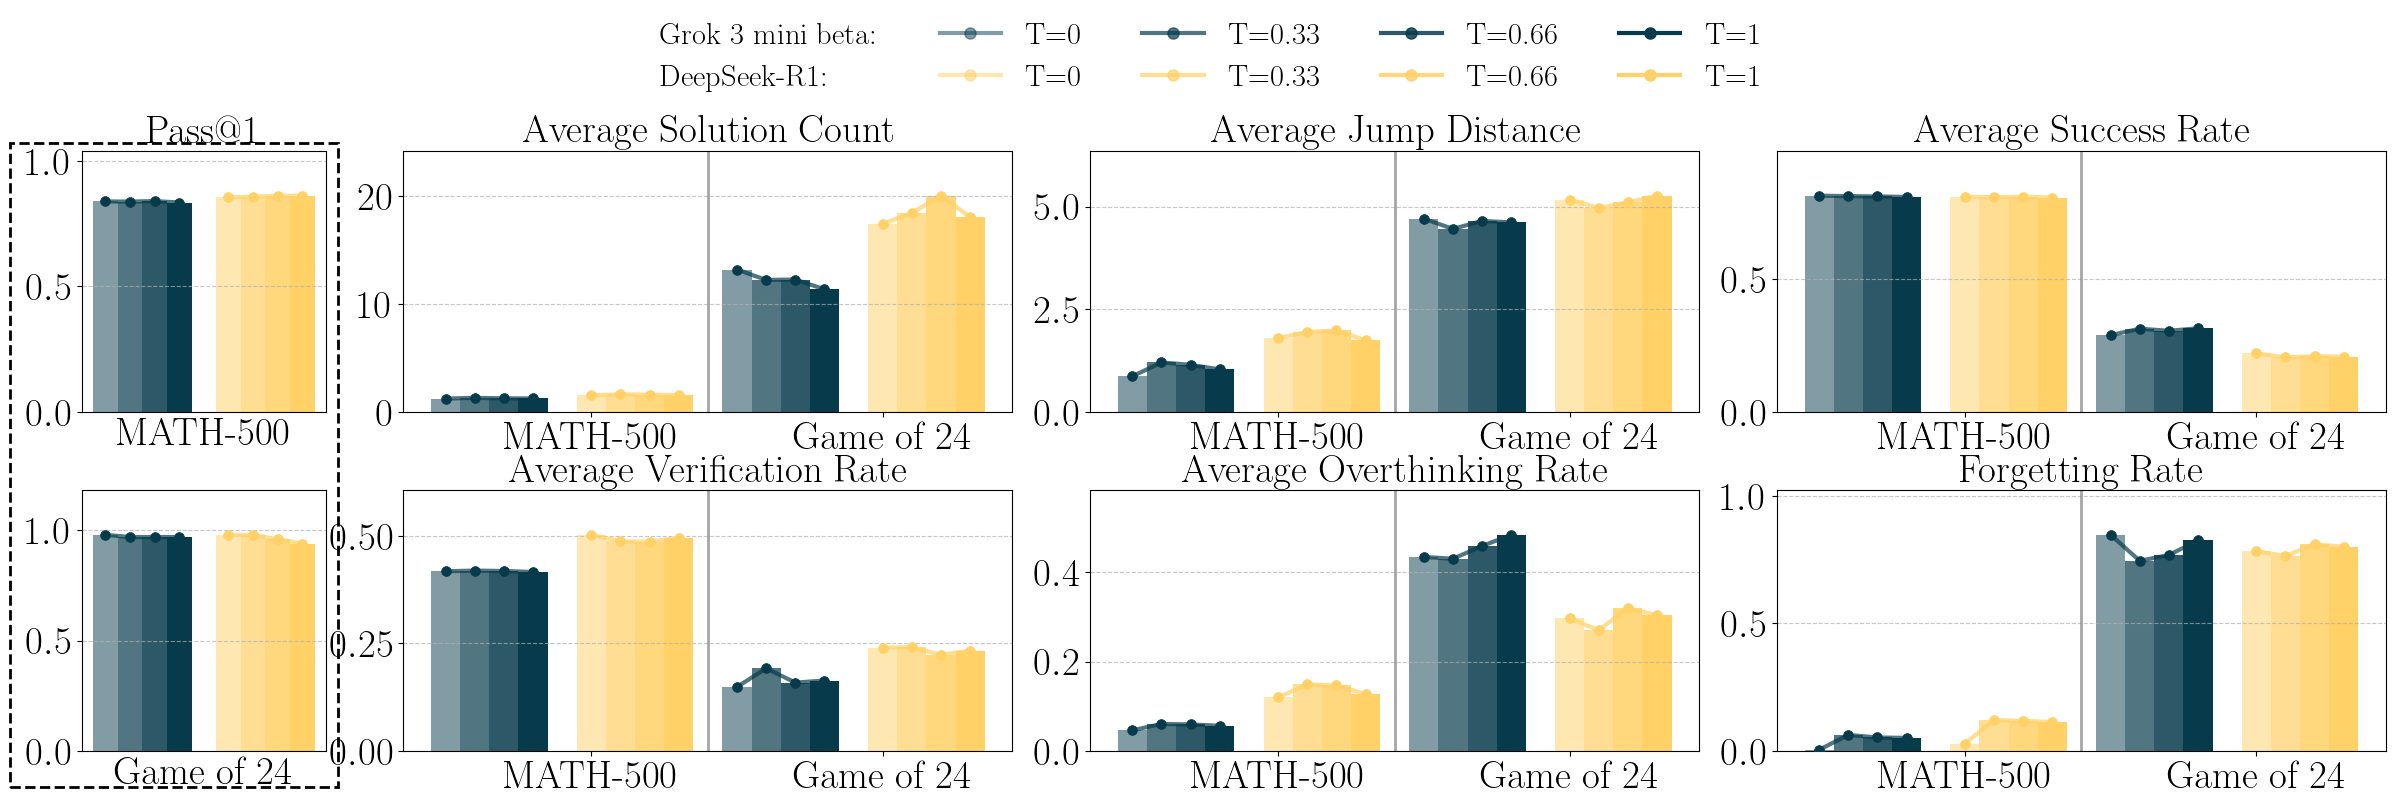

In [19]:
this_metrics = [
    "average_correlation",  # Put average_correlation first
    "average_solution_count",
    "filtered_ajd",
    "average_success_rate",
    "overall_average_verification_rate",
    "average_overthinking_rate",
    "average_forgetting_rate",
]

# Create a figure with 2 rows and 4 columns (correlation on left, other metrics on right)
fig, axs = plt.subplots(2, 4, gridspec_kw={'width_ratios': [0.4, 1, 1, 1]})  # Reduced width ratio for correlation column
fig.subplots_adjust(left=0.035, bottom=.05, right=0.995, top=.8, wspace=0.15, hspace=0.3)
fig.set_size_inches(24, 8) 

# Set width of bars
bar_width = 0.1  # For the right side plots with multiple datasets and temperatures
correlation_bar_width = 0.1  # Narrower bars for the correlation plot to fit all temperatures

# Set positions of the bars on X axis
index = np.arange(len(final_datasets))

# Restructure data for plotting
# First, create a dictionary where metrics are the top level keys
restructured_metrics = {}
for metric in this_metrics[1:]:  # Skip correlation for now
    restructured_metrics[metric] = {}
    for model in models:
        restructured_metrics[metric][model] = {}
        for temp in temperatures:
            restructured_metrics[metric][model][temp] = []
            for dataset in final_datasets:
                restructured_metrics[metric][model][temp].append(reasoning_metrics[dataset][model][temp][metric])

# Set the title for the correlation column
metric = "average_correlation"
axs[0, 0].set_title(metrics[metric]["label"], fontsize=28)

# Plot the correlation metric separately in the first column
for i, dataset_key in enumerate(final_datasets):
    dataset_name = final_datasets[dataset_key]
    
    # Plot bars for each model with spacing between groups
    for j, model in enumerate(models):
        # Position the bars with space between model groups but not between temperatures
        model_offset = 0.1 if j >= 2 else 0  # Add space between model groups
        
        # Store bar positions and heights for connecting lines
        bar_positions = []
        bar_heights = []
        
        for t, temp in enumerate(temperatures):
            # Calculate position for each temperature bar within the model group
            position = j * correlation_bar_width * 5 + t * correlation_bar_width + model_offset  # Increased multiplier from 4 to 5 for more space
            bar_positions.append(position)
            
            value = reasoning_metrics[dataset_key][model][temp][metric]
            bar_heights.append(value)
            
            axs[i, 0].bar(position, value, 
                      correlation_bar_width, 
                      label=f"{models[model]['label']} (T={temp})" if i == 0 and t == 0 else "", 
                      color=models[model]["color"],
                      alpha=alphas[t])
            
            # Add dots at the top of each bar
            axs[i, 0].scatter(position, value, color=models[model]["color"], s=50, zorder=10)
        
        # Add connecting line at the top of bars
        axs[i, 0].plot(bar_positions, bar_heights, color=models[model]["color"], alpha=0.7, linewidth=3)
    
    # Add value labels on top of bars (only for the highest temperature for clarity)
    for j, model in enumerate(models):
        model_offset = 0.1 if j >= 2 else 0
        for t, temp in enumerate(temperatures):
            position = j * correlation_bar_width * 4.5 + t * correlation_bar_width + model_offset  # Increased multiplier from 4 to 5
            value = reasoning_metrics[dataset_key][model][temp][metric]
            
    
    # Set xlabel as dataset name instead of title
    axs[i, 0].set_xlabel(dataset_name, fontsize=28)
    axs[i, 0].set_xticks([])
    axs[i, 0].grid(axis='y', linestyle='--', alpha=0.7)
    
    current_ylim = axs[i, 0].get_ylim()
    axs[i, 0].set_ylim(0, current_ylim[1] * 1.15)  # Add 15% padding at the top

# Add a dashed box around the correlation subplots
# Get the position of the first column of subplots
pos0 = axs[0, 0].get_position()
pos1 = axs[1, 0].get_position()
# Create a rectangle patch to surround both correlation subplots
rect = plt.Rectangle(
    (pos0.x0 - 0.03, pos1.y0 - 0.045),  # x, y (bottom left corner)
    pos0.width + 0.035,  # width
    pos0.y0 + pos0.height - pos1.y0 + 0.055,  # height
    linewidth=2,
    linestyle='dashed',
    edgecolor='black',
    facecolor='none',
    zorder=1000,
    transform=fig.transFigure
)
fig.add_artist(rect)

# Create the bar plots for the remaining metrics
for i, metric in enumerate(this_metrics[1:]):  # Skip correlation which we already plotted
    row = i // 3
    col = (i % 3) + 1  # +1 because first column is for correlation
    
    # Calculate positions for bars - centered better
    for j, model in enumerate(models):
        model_offset = 0.1 if j >= 2 else 0  # Add space between model groups
        
        for t, temp in enumerate(temperatures):
            # Calculate position for each temperature bar within the model group
            positions = []
            values = []
            for k in range(len(final_datasets)):
                # Increased multiplier from 4 to 5 for more space between temperature groups
                pos = k - bar_width * 10 + j * bar_width * 5 + t * bar_width + model_offset  # Increased from 8 to 10 and 4 to 5
                positions.append(pos)
                values.append(restructured_metrics[metric][model][temp][k])
            
            axs[row, col].bar(positions, values, 
                      bar_width, 
                      label=f"{models[model]['label']} (T={temp})" if i == 0 and j == 0 and t == 0 else "", 
                      color=models[model]["color"],
                      alpha=alphas[t])
            
            # Add dots at the top of each bar
            for pos, val in zip(positions, values):
                axs[row, col].scatter(pos, val, color=models[model]["color"], s=50, zorder=10)
            
            # Add connecting line at the top of bars for each temperature
            if t == len(temperatures) - 1:  # After plotting all temperatures for this model
                for dataset_idx in range(len(final_datasets)):
                    # Collect all positions and heights for this dataset and model across temperatures
                    dataset_positions = []
                    dataset_heights = []
                    for temp_idx, temp_val in enumerate(temperatures):
                        # Increased multiplier from 4 to 5 for more space between temperature groups
                        pos = dataset_idx - bar_width * 9 + j * bar_width * 5 + temp_idx * bar_width + model_offset
                        dataset_positions.append(pos)
                        dataset_heights.append(restructured_metrics[metric][model][temp_val][dataset_idx])
                    
                    # Draw the connecting line
                    axs[row, col].plot(np.array(dataset_positions)-0.1, dataset_heights, color=models[model]["color"], alpha=0.7, linewidth=3)
    
    axs[row, col].set_title(metrics[metric]["label"], fontsize=28)
    axs[row, col].set_xticks(index-0.5)  # Center ticks on clusters
    axs[row, col].set_xticklabels(final_datasets.values())
    axs[row, col].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add a solid line to separate MATH-500 and Game of 24
    axs[row, col].axvline(x=-0.1, color='gray', linestyle='-', linewidth=2, alpha=0.7)
    
    current_ylim = axs[row, col].get_ylim()
    axs[row, col].set_ylim(0, current_ylim[1] * 1.15)  # Add 15% padding at the top
    

# Build custom legend entries
legend_elements = []

# First row: Grok 3 mini beta
# Dummy handle for the model name
legend_elements.append(
    plt.Line2D([], [], linestyle='None', linewidth=0,
               label=f"{models['xai/grok-3-mini-beta']['label']}:")
)
# One handle per temperature
for t, temp in enumerate(temperatures):
    legend_elements.append(
        plt.Line2D([0], [0],
                   color=models['xai/grok-3-mini-beta']['color'],
                   marker='o', markersize=8, linewidth=3,
                   alpha=alphas[t], label=f"T={temp}")
    )

# Second row: DeepSeek-R1
legend_elements.append(
    plt.Line2D([], [], linestyle='None', linewidth=0,
               label=f"{models['deepseek-ai/deepseek-reasoner']['label']}:")
)
for t, temp in enumerate(temperatures):
    legend_elements.append(
        plt.Line2D([0], [0],
                   color=models['deepseek-ai/deepseek-reasoner']['color'],
                   marker='o', markersize=8, linewidth=3,
                   alpha=alphas[t], label=f"T={temp}")
    )

# Reorder the legend elements to group model name with its temperatures
reordered_legend_elements = []
reordered_legend_elements.append(legend_elements[0])  # Grok model name
reordered_legend_elements.append(legend_elements[5])  # DeepSeek model name
for i in range(1, 5):
    reordered_legend_elements.append(legend_elements[i])    # Grok temperature
    reordered_legend_elements.append(legend_elements[i+5])  # DeepSeek temperature


# Place the legend with 5 columns so it wraps into two rows of 5
axs[row, col].legend(
    handles=reordered_legend_elements,
    ncol=5,
    loc='upper center',
    bbox_to_anchor=(-1, 2.9),
    fontsize=22,
    frameon=False,
)

plt.savefig(f"{root_dir}/figures/decoding.pdf")


In [9]:
temperature_pairs = list(itertools.combinations(temperatures, 2))
similarities = {"tree": {}, "walk": {}}



for model_name in models:
    for temperature1, temperature2 in temperature_pairs:
        for dataset in final_datasets:
            row = get_row(
                compare_results,
                model1=model_name,
                model2=model_name,
                dataset=dataset,
                temperature1=temperature1,
                temperature2=temperature2,
            )
            similarities["tree"][(model_name, dataset, temperature1, temperature2)] = row.iloc[0]["tree_similarity"]
            similarities["walk"][(model_name, dataset, temperature1, temperature2)] = row.iloc[0]["walk_similarity"]
        
    

NameError: name 'make_axes_locatable' is not defined

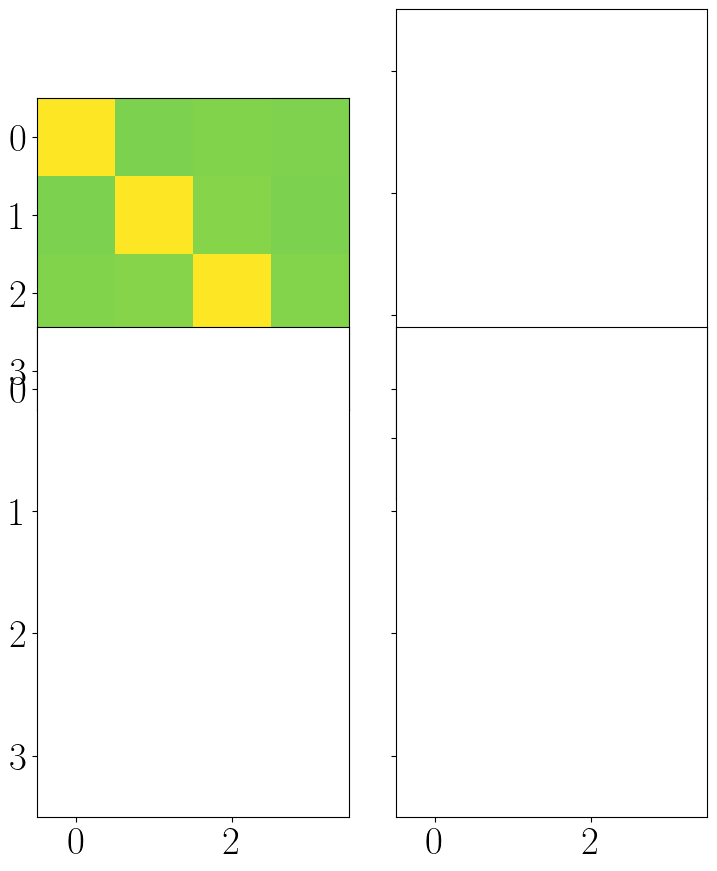

In [10]:
# Create figures for each model comparing different temperatures
for model_name in models:
    # Create a figure with 4 subplots (2x2 grid) for the heatmaps
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.subplots_adjust(left=0.28, bottom=.1, right=0.95, top=1.05, wspace=0.15, hspace=-0.35)
    fig.set_size_inches(10, 8.5)

    # Define the metrics and datasets for the subplots
    similarity_metrics = ["tree", "walk"]
    datasets_list = list(final_datasets.keys())

    # Create a mapping for temperature values to indices for the heatmap
    temp_indices = {temp: i for i, temp in enumerate(temperatures)}
    temp_labels = [f"T={temp}" for temp in temperatures]

    # Create the heatmaps
    for dataset_idx, dataset in enumerate(datasets_list[:2]):  # Using first two datasets
        for metric_idx, metric in enumerate(similarity_metrics):
            # Calculate subplot index
            current_ax = axs[dataset_idx, metric_idx]
            
            # Create empty similarity matrix
            sim_matrix = np.zeros((len(temperatures), len(temperatures)))
            
            # Fill diagonal with 1.0 (self-similarity)
            np.fill_diagonal(sim_matrix, 1.0)
            
            # Fill the matrix with similarity values
            for temp1, temp2 in temperature_pairs:
                i, j = temp_indices[temp1], temp_indices[temp2]
                # Get similarity value, defaulting to NaN if not found
                sim_value = similarities[metric].get((model_name, dataset, temp1, temp2), np.nan)
                sim_matrix[i, j] = sim_value
                sim_matrix[j, i] = sim_value  # Symmetrical matrix
            
            # Create heatmap
            im = current_ax.imshow(sim_matrix, cmap='viridis', vmin=0, vmax=1)
            
            # Add colorbar with the same height as the heatmap
            divider = make_axes_locatable(current_ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cbar = plt.colorbar(im, cax=cax)
            
            # Make the colorbar tick labels smaller
            cbar.ax.tick_params(labelsize=18)
            
            # Set title and labels
            current_ax.set_xticks(np.arange(len(temperatures)))
            current_ax.set_yticks(np.arange(len(temperatures)))
            current_ax.set_xticklabels(temp_labels, rotation=45, ha="right", fontsize=22)
            current_ax.set_yticklabels(temp_labels, fontsize=22)
            
            # Add text annotations in the heatmap cells
            for i in range(len(temperatures)):
                for j in range(len(temperatures)):
                    text_color = "white" if sim_matrix[i, j] < 0.5 else "black"
                    current_ax.text(j, i, f"{sim_matrix[i, j]:.2f}", 
                                    ha="center", va="center", color=text_color, fontsize=18)

    # Add y-axis labels for each row (dataset name)
    for dataset_idx, dataset in enumerate(datasets_list[:2]):
        # Add label to the first subplot of each row
        axs[dataset_idx, 0].set_ylabel(final_datasets[dataset], fontsize=28, fontweight='bold')

    # Add x-axis labels at the top for each column (metric name)
    for metric_idx, metric in enumerate(similarity_metrics):
        # Add label to the top subplot of each column
        axs[0, metric_idx].set_title(f"{metric.capitalize()} Similarity", fontsize=28, fontweight='bold')
    
    # Add model name as figure title
    fig.suptitle(models[model_name]["label"], fontsize=32, fontweight='bold', y=1.15)

    plt.savefig(f"{root_dir}/figures/decoding_similarities_{model_name.replace('/', '-')}.pdf")
    plt.show()
